# Classifying different dental conditions

**British university in Egypt** \\
*ICS*

---

### STUDENT DETAIL:
- **Omar Islam**
  - Email: omar219127@bue.edu.eg
  - Student ID: 219127


---




## Contribution:
1. Implementing OralVision which is a deep learning model that will be used to classify 6 oral disease.


### Approach:
  *   **Model**: EfficientNet-B3 with mixed precision training and test-time augmentation.
  *   **Training**: AdamW optimizer, label-smoothed loss, early stopping.
  *   **Evaluation**: Accuracy, confusion matrices, Grad-CAM for interpretability.






In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00


### Loading the dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salmansajid05/oral-diseases")

print("Path to dataset files:", path)

100%|██████████| 235M/235M [00:09<00:00, 26.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3


In [3]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3"

for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files[:5]}")  # Show first 5 files in each directory
    print("-" * 50)

Directory: /root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3
Subdirectories: ['Data caries', 'Tooth Discoloration', 'Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset', 'hypodontia', 'Mouth Ulcer', 'Calculus', 'Gingivitis']
Files: []
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3/Data caries
Subdirectories: ['Data caries']
Files: []
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3/Data caries/Data caries
Subdirectories: ['caries augmented data set', 'caries orignal data set']
Files: []
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3/Data caries/Data caries/caries augmented data set
Subdirectories: ['preview']
Files: []
--------------------------------------------------
Directory: /root/.cache/kaggle

### Necessary Imports:

In [4]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.cuda.amp as amp
from torchvision.models import efficientnet_b3
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings("ignore")

### Set random seed for reproducibility

In [5]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

### Define original directories

In [6]:
downloaded_dataset_base_path = "/root/.cache/kagglehub/datasets/salmansajid05/oral-diseases/versions/3"

original_dirs = {
    'Calculus': os.path.join(downloaded_dataset_base_path, 'Calculus', 'Calculus'),
    'Caries': os.path.join(downloaded_dataset_base_path, 'Data caries', 'Data caries', 'caries augmented data set', 'preview'),
    'Gingivitis': os.path.join(downloaded_dataset_base_path, 'Gingivitis', 'Gingivitis'),
    'Ulcers': os.path.join(downloaded_dataset_base_path, 'Mouth Ulcer', 'Mouth Ulcer', 'Mouth_Ulcer_augmented_DataSet', 'preview'),
    'Tooth Discoloration': os.path.join(downloaded_dataset_base_path, 'Tooth Discoloration', 'Tooth Discoloration ', 'Tooth_discoloration_augmented_dataser', 'preview'),
    'Hypodontia': os.path.join(downloaded_dataset_base_path, 'hypodontia', 'hypodontia')
}

### Define target base directory

In [7]:
base_dir = '/kaggle/working/dataset'
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

## Preprocessing the data
1. Create target directories
2. Function to copy and split images
3. Organize dataset

In [8]:
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

In [9]:
def copy_and_count_images(class_name, image_paths):
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)
    split_paths = {'train': train_paths, 'val': val_paths, 'test': test_paths}
    for split, paths in split_paths.items():
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

In [10]:
for class_name, original_dir in original_dirs.items():
    image_paths = [os.path.join(root, file) for root, _, files in os.walk(original_dir)
                   for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    if image_paths:
        copy_and_count_images(class_name, image_paths)

print("Images organized successfully.")

Images organized successfully.


## Data augmentation

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Load datasets

In [12]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_transforms)
test_dataset = ImageFolder(test_dir, transform=val_transforms)

### Data loaders with optimized settings

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


# EfficientNet-B3 model

In [14]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.model = efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

## Initializing the model

In [15]:
num_classes = len(train_dataset.classes)
model = CustomEfficientNet(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 220MB/s]


CustomEfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (

## Optimizer and loss

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

### Mixed precision scaler

In [17]:
scaler = amp.GradScaler()

## Training loop with mixed precision

In [18]:
num_epochs = 50
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            break

    scheduler.step(val_loss)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Test-time augmentation (TTA) with fix
def tta_predict(model, loader, num_augmentations=5):
    model.eval()
    test_preds, test_true = [], []
    tta_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_preds = []
            for _ in range(num_augmentations):
                # Denormalize
                denorm_inputs = inputs * torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1) + \
                                torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
                denorm_inputs = denorm_inputs.clamp(0, 1) * 255
                denorm_inputs = denorm_inputs.byte()

                aug_inputs = torch.stack([tta_transforms(Image.fromarray(
                    denorm_inputs[i].cpu().permute(1, 2, 0).numpy()))
                    for i in range(inputs.size(0))]).to(device)
                outputs = model(aug_inputs)
                batch_preds.append(outputs.softmax(dim=1))
            avg_preds = torch.stack(batch_preds).mean(0)
            _, predicted = torch.max(avg_preds, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_true.extend(labels.cpu().numpy())

    return test_true, test_preds

# Evaluate with TTA
test_true, test_preds = tta_predict(model, test_loader)
test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy with TTA: {test_acc:.4f}')

Epoch [1/50], Train Loss: 0.8269, Val Loss: 0.6730, Val Acc: 0.8770
Epoch [2/50], Train Loss: 0.6603, Val Loss: 0.6737, Val Acc: 0.8749
Epoch [3/50], Train Loss: 0.6108, Val Loss: 0.6188, Val Acc: 0.8956
Epoch [4/50], Train Loss: 0.6032, Val Loss: 0.5980, Val Acc: 0.9059
Epoch [5/50], Train Loss: 0.5805, Val Loss: 0.5856, Val Acc: 0.9101
Epoch [6/50], Train Loss: 0.5719, Val Loss: 0.5821, Val Acc: 0.9044
Epoch [7/50], Train Loss: 0.5665, Val Loss: 0.5971, Val Acc: 0.9116
Epoch [8/50], Train Loss: 0.5655, Val Loss: 0.5860, Val Acc: 0.9106
Epoch [9/50], Train Loss: 0.5555, Val Loss: 0.5933, Val Acc: 0.9121
Epoch [10/50], Train Loss: 0.5527, Val Loss: 0.6258, Val Acc: 0.8935
Epoch [11/50], Train Loss: 0.5331, Val Loss: 0.5436, Val Acc: 0.9271
Epoch [12/50], Train Loss: 0.5158, Val Loss: 0.5383, Val Acc: 0.9313
Epoch [13/50], Train Loss: 0.5124, Val Loss: 0.5430, Val Acc: 0.9282
Epoch [14/50], Train Loss: 0.5113, Val Loss: 0.5370, Val Acc: 0.9313
Epoch [15/50], Train Loss: 0.5087, Val Loss

## Plotting loss and accuracy

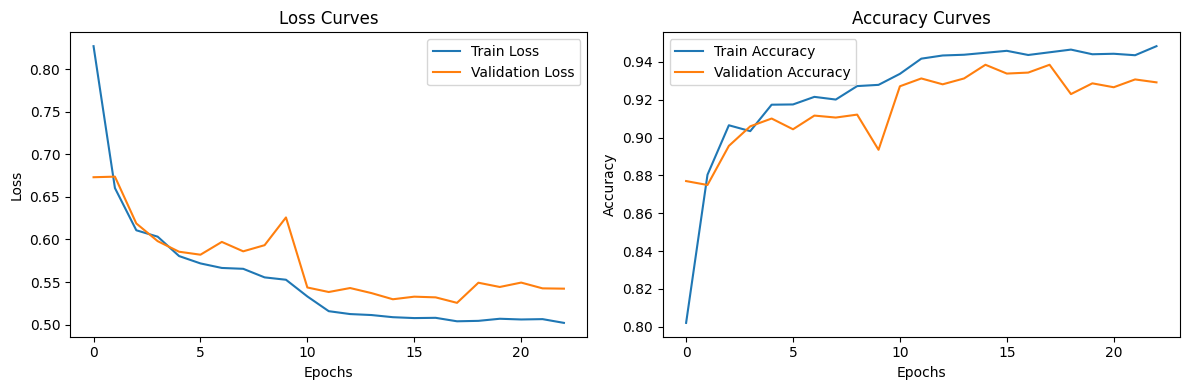

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.show()

## Classification report and confusion matrix

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.74      0.78      0.76       130
             Caries       0.99      0.98      0.99       239
         Gingivitis       0.86      0.85      0.85       234
         Hypodontia       0.97      0.89      0.93        35
Tooth Discoloration       0.98      0.98      0.98       184
             Ulcers       0.99      0.99      0.99       255

           accuracy                           0.93      1077
          macro avg       0.92      0.91      0.92      1077
       weighted avg       0.93      0.93      0.93      1077



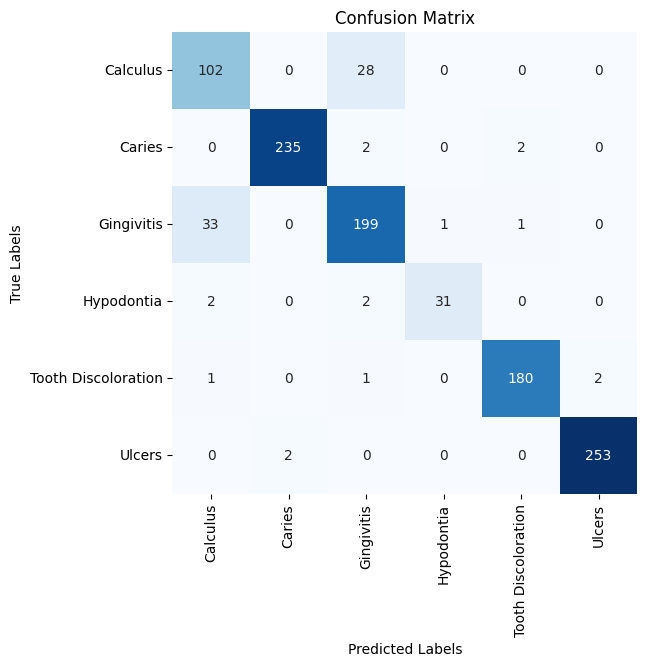

In [20]:
class_names = test_dataset.classes
print("Classification Report:")
print(classification_report(test_true, test_preds, target_names=class_names))
conf_mat = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualizing the dataset

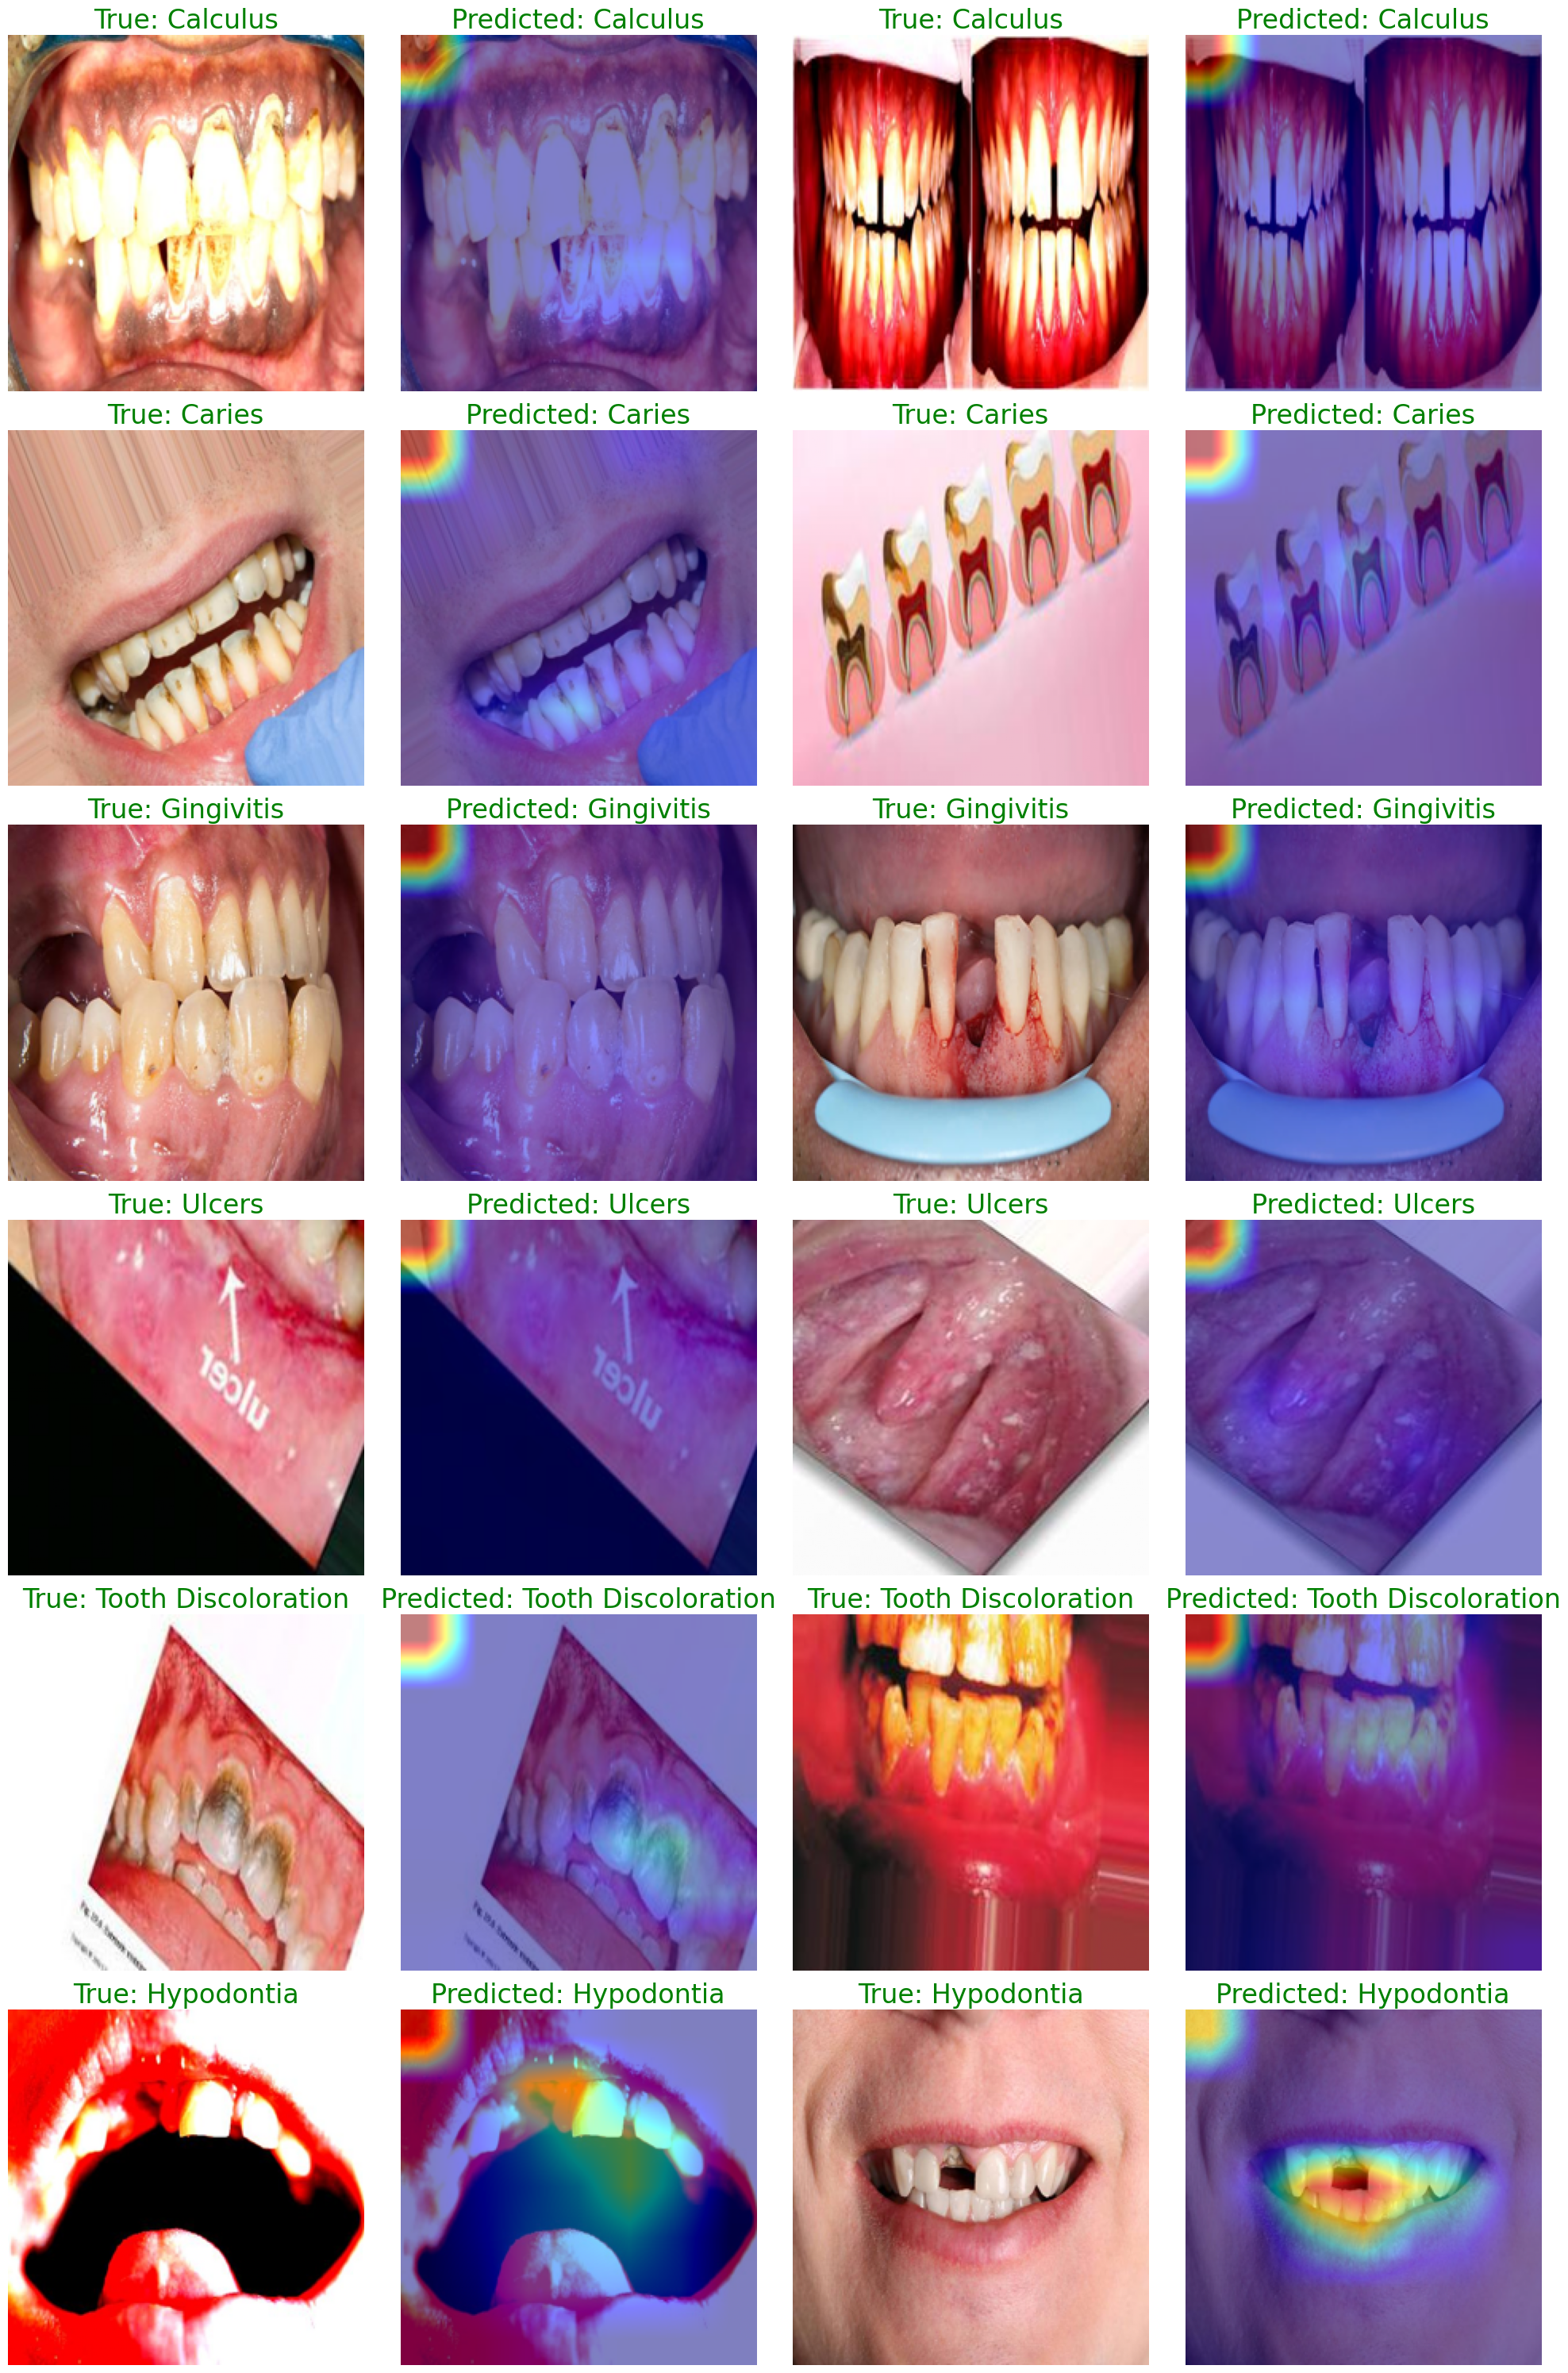

In [21]:
def visualize_grad_cam(image_paths, model, device, class_names):
    num_images = len(image_paths)
    num_rows = (num_images + 1) // 2
    plt.figure(figsize=(20, 5 * num_rows))

    target_layer = model.model.features[-1]  # Last conv layer in EfficientNet
    grad_cam = GradCAM(model=model, target_layers=[target_layer])

    for idx, image_path in enumerate(image_paths):
        input_image = Image.open(image_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image).unsqueeze(0).to(device)

        grayscale_cam = grad_cam(input_tensor)[0]
        input_image_np = np.array(input_image.resize((224, 224))) / 255.0
        visualization = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
        true_class = os.path.basename(os.path.dirname(image_path))
        title_color = 'green' if true_class == predicted_class else 'red'

        plt.subplot(num_rows, 4, 2 * idx + 1)
        plt.imshow(input_image_np)
        plt.title(f'True: {true_class}', fontsize=24, color=title_color)
        plt.axis('off')
        plt.subplot(num_rows, 4, 2 * idx + 2)
        plt.imshow(visualization)
        plt.title(f'Predicted: {predicted_class}', fontsize=24, color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# Get random test images and visualize Grad-CAM
random_images = [os.path.join(test_dir, cls, random.choice(os.listdir(os.path.join(test_dir, cls))))
                 for cls in classes for _ in range(2)]
visualize_grad_cam(random_images, model, device, class_names)